This section is a small project that uses pyAudioKits to read and extract audio features, and then uses deep learning methods for speech recognition. We will extract the Mel spectrum as features and use Keras+Tensorflow to build a simple convolutional neural network classifier to achieve the recognition of ten speech digits from 0-9.

* The dataset used is from: https://www.kaggle.com/datasets/bharatsahu/speech-commands-classification-dataset. Please download the dataset and save it to the "speech-commands-classification-dataset" directory. 

* Algorithm reference from: https://www.kaggle.com/code/ritvik1909/speech-classification-spectrogram-cnn


In [1]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, models, callbacks
from keras.preprocessing.image import ImageDataGenerator
import pyAudioKits.audio as ak
import pyAudioKits.analyse as aly

In [2]:
#构造预处理数据路径
root="speech-commands-classification-dataset"
train_folders="train_set"
val_folders="val_set"
test_folders="test_set"
if not os.path.exists(train_folders):
    os.mkdir(train_folders)
if not os.path.exists(val_folders):
    os.mkdir(val_folders)
if not os.path.exists(test_folders):
    os.mkdir(test_folders)

<Figure size 432x288 with 0 Axes>

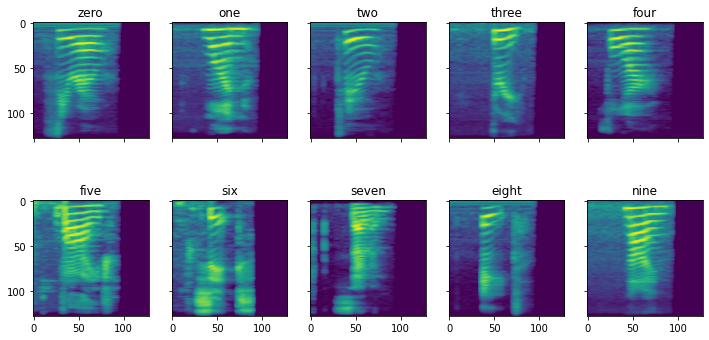

In [8]:
input_size = (128, 128, 1)
labels=["zero","one","two","three","four","five","six","seven","eight","nine"]


plt.tight_layout()
fig,axes=plt.subplots(2,5,sharex=True,sharey=True)
fig.set_size_inches(12,6)

#Iterate over the training set, validation set and test set, and obtain the first sample under each speech digit
for i,d in enumerate(labels):
    path=root+"/"+d
    for w in os.listdir(path):
        wf = ak.read_Audio(path+"/"+w)  #Reading speech digit
        wf = wf.padding(22050)  #Zero-padding the sample length of the speech digits to 22050, half the sampling rate, so that the same resolution can be used in the frequency and time domains
        features= aly.melSpec(wf, spec_h = input_size[0], spec_w= input_size[1])    #Extract the Mel spectrum and set the width and height to 128, where the height determines the frequency resolution of the Mel spectrum and the width determines the time resolution
        axes[int(i/5),i%5].set_title(d)
        axes[int(i/5),i%5].imshow(features) #Plot the Mel Spectrum Features
        break

In [ ]:
val_list=[str(i)[2:-3] for i in open(root+"/validation_list.txt","rb").readlines()]
test_list=[str(i)[2:-3] for i in open(root+"/testing_list.txt","rb").readlines()]

maxcount=[1839,239,230]

for d in labels:
    count=[0,0,0]
    path=root+"/"+d
    dst=[None,None,None]
    dst[0]=train_folders+"/"+d
    dst[1]=val_folders+"/"+d
    dst[2]=test_folders+"/"+d
    for w in os.listdir(path):
        if d+"/"+w in val_list: #If it is in val_list, it is categorized to the validation set
            pos=1
        elif d+"/"+w in test_list: #If it is in test_list, it is categorized into test sets
            pos=2
        else:   #Otherwise, categorize to training set
            pos=0
        count[pos]+=1
        if count[pos]>maxcount[pos]:
            continue
        wf = ak.read_Audio(path+"/"+w)
        wf = wf.padding(22050)
        features= aly.melSpec(wf, spec_h = input_size[0], spec_w= input_size[1])
        if not os.path.exists(dst[pos]):
            os.mkdir(dst[pos])
        if not os.path.exists(dst[pos]):
            os.mkdir(dst[pos])
        plt.imsave(dst[pos]+"/"+w[:-4]+".png", features, cmap='gray')   #Save Mel spectrum features as images
    print(d)

zero
one
two
three
four
five
six
seven
eight
nine


In [ ]:
#Load the image dataset, thus essentially transforming the speech classification problem into an image classification problem
training_set = ImageDataGenerator().flow_from_directory(
    train_folders, target_size=input_size[:-1],  batch_size=32, class_mode='categorical', color_mode='grayscale'
)
validation_set = ImageDataGenerator().flow_from_directory(
    val_folders, target_size=input_size[:-1],  batch_size=32, class_mode='categorical', color_mode='grayscale'
)
test_set = ImageDataGenerator().flow_from_directory(
    test_folders, target_size=input_size[:-1],  batch_size=32, class_mode='categorical', color_mode='grayscale'
)

Found 18390 images belonging to 10 classes.
Found 2369 images belonging to 10 classes.
Found 2300 images belonging to 10 classes.


In [ ]:
#Constructing Convolutional Neural Networks
model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(128,128,1), padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(labels), activation='softmax'),
])

model.summary()
#Adam is used for the optimizer; cross-entropy loss function is used for the loss function; accuracy is used for the earlystopping metric
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [ ]:
#Using earlystopping and learning rate decay strategies
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

rlp = callbacks.ReduceLROnPlateau(    monitor='val_loss', factor=0.1, patience=2, min_lr=1e-10, mode='min', verbose=1)

#Training Model
history = model.fit(
    training_set, validation_data=validation_set,
    epochs=500, callbacks=[es, rlp], batch_size=8
)

Epoch 1/500
575/575 [==============================] - 921s 2s/step - loss: 2.1807 - accuracy: 0.1993 - val_loss: 1.9604 - val_accuracy: 0.2921
Epoch 2/500
575/575 [==============================] - 820s 1s/step - loss: 1.8535 - accuracy: 0.3332 - val_loss: 1.7405 - val_accuracy: 0.3854
Epoch 3/500
575/575 [==============================] - 832s 1s/step - loss: 1.6132 - accuracy: 0.4388 - val_loss: 1.4009 - val_accuracy: 0.5395
Epoch 4/500
575/575 [==============================] - 824s 1s/step - loss: 1.2987 - accuracy: 0.5673 - val_loss: 1.1822 - val_accuracy: 0.5741
Epoch 5/500
575/575 [==============================] - 824s 1s/step - loss: 1.0400 - accuracy: 0.6605 - val_loss: 0.8329 - val_accuracy: 0.7341
Epoch 6/500
575/575 [==============================] - 841s 1s/step - loss: 0.8287 - accuracy: 0.7354 - val_loss: 0.7591 - val_accuracy: 0.7455
Epoch 7/500
575/575 [==============================] - 836s 1s/step - loss: 0.7186 - accuracy: 0.7748 - val_loss: 0.6612 - val_accuracy:

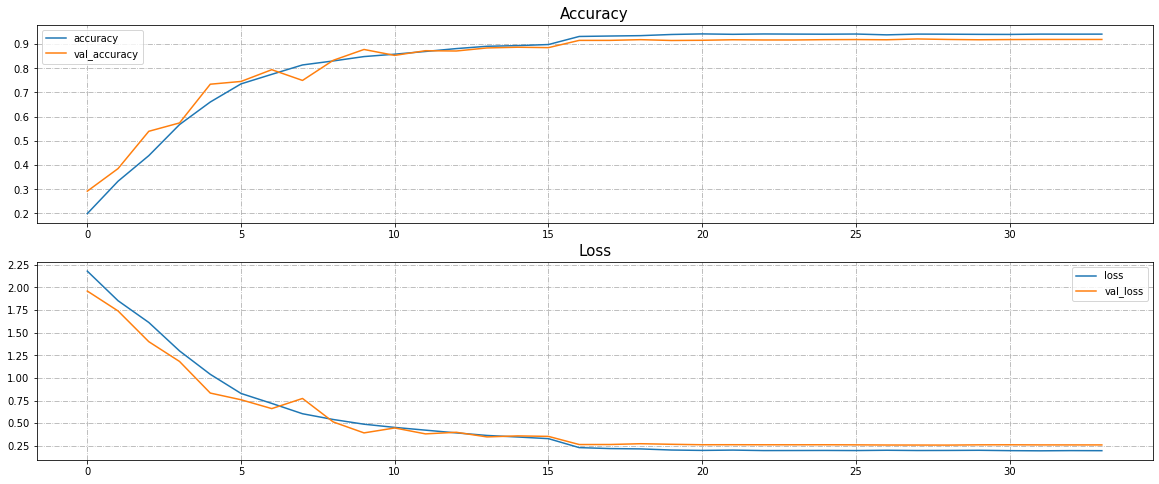

In [ ]:
import pandas as pd

#Plotting loss and accuracy over time on the training and validation sets

fig, ax = plt.subplots(2, 1, figsize=(20, 8))

df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])

df[['loss', 'val_loss']].plot(ax=ax[1])

ax[0].set_title('Accuracy', fontsize=15)
ax[1].set_title('Loss', fontsize=15)

ax[0].grid(linestyle="-.")
ax[1].grid(linestyle="-.")

In [ ]:
#Test set loss of 0.245 and accuracy of 0.93
model.evaluate(test_set)

72/72 [==============================] - 24s 331ms/step - loss: 0.2450 - accuracy: 0.9304


[0.24495860934257507, 0.9304347634315491]